In [21]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
import pandas as pd


from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction
from acled_conflict_analysis import visuals
from datetime import datetime

# Import the OAuth authentication function
from acled_conflict_analysis.acled_auth import *

# Load environment variables
load_dotenv()

# Get Mapbox basemap URL from environment
MAPBOX_BASEMAP_URL = os.getenv("MAPBOX_BASEMAP_URL", "")

# Analysing Spatial Distribution of Conflict before and after the fall of the Assad Regime

In [22]:
COUNTRIES_OF_INTEREST = ["Syria"]

TODAY_DATE = datetime.today().date().isoformat()

START_DATE = "2023-11-23"
END_DATE = TODAY_DATE

In [23]:
# ============================
# LOAD AND PREPROCESS DATA
# ============================
# Load environment variables from .env file
# to ensure we can access API keys
load_dotenv()

# Extract the data
# Test single call to check for duplicate prints
print("🧪 Testing acled_api function for duplicate prints...")

data = extraction.acled_api(
    # email = acled_email,
    # password = acled_password,
    country_codes=COUNTRIES_OF_INTEREST,
    start_date=START_DATE,
    end_date=END_DATE,  # Small date range for quick test
)
# Perfom data conversion
processing.data_type_conversion(data)

🧪 Testing acled_api function for duplicate prints...
🔄 Using cached OAuth token
URL: https://acleddata.com/api/acled/read
Parameters: {'_format': 'json', 'limit': 4000000, 'iso': '760', 'event_date': '2023-11-23|2026-01-26', 'event_date_where': 'BETWEEN', 'population': 'full', 'fields': 'region|country|iso|year|event_date|source|admin1|admin2|admin3|location|event_type|sub_event_type|interaction|fatalities|timestamp|latitude|longitude|actor1|actor2|notes|population_1km|population_5km|population_2km|population_best'}


/Users/ssarva/syria-economic-monitor/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ Successfully retrieved 28371 records


In [24]:
data["nrEvents"] = 1
data = data[data["event_type"] != "Strategic developments"]

In [25]:
def get_conflict_category(date):
    if date <= pd.Timestamp("2024-11-27") and date >= pd.Timestamp("2023-11-26"):
        return "Before Regime Change"
    elif date >= pd.Timestamp("2024-12-08") and date <= pd.Timestamp("2025-12-09"):
        return "After Regime Change"

In [26]:
data.loc[:, "category"] = data["event_date"].apply(get_conflict_category)
extracted_date = datetime.today().date().isoformat()
extracted_date_formatted = datetime.today().strftime("%B %d, %Y")

In [27]:
data.to_csv(f"../../data/conflict/raw_acled_{extracted_date}.csv")
data = pd.read_csv(f"../../data/conflict/raw_acled_{extracted_date}.csv")
processing.data_type_conversion(data)

In [28]:
conflict_daily = processing.get_acled_by_group(
    data, columns=["latitude", "longitude", "category"], freq="D"
)

In [29]:
daily_mean = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities"]
    ]
    .mean()
    .reset_index()
)
daily_median = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities"]
    ]
    .median()
    .reset_index()
)

In [30]:
daily_mean = processing.convert_to_gdf(daily_mean)
daily_median = processing.convert_to_gdf(daily_median)

In [31]:
import geopandas as gpd

syria_adm1 = gpd.read_file("../../data/boundaries/syr_admin1.shp")
syria_adm0 = gpd.read_file("../../data/boundaries/syr_admin0.shp")

### Mean Conflict Index

The conflict intensity index is calculated as the geometric mean of conflict events and fatalities, with an adjustment to handle zero values:

$$\text{Conflict Intensity Index} = \sqrt{(\text{nrEvents}) \times (\text{nrFatalities} + 1)}$$

Where:
- $\text{nrEvents}$ is the number of conflict events in a given period and location
- $\text{nrFatalities}$ is the number of fatalities from conflicts in the same period and location
- The addition of 1 to each term ensures the index is defined even when either component is zero. This is arbitrary and is doen just to account for 0 values of fatalities and conflicts. 

This index provides a balanced measure that accounts for both the frequency of conflicts and their severity.  Compared to arithmetic means, the geometric mean reduces the influence of extreme values in either component (conflict events + fatalities). Areas with both high events and high fatalities will have higher index values than areas with many events but few fatalities or vice versa.

Conflict index is calculated at the location and then average is taken over time (across the three time periods). This is to preserve the integrity of the conflict index in that specific location. 

In [32]:
import numpy as np

conflict_daily["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily["nrEvents"]) * (conflict_daily["nrFatalities"] + 1)
)

In [35]:
daily_conflict_intensity = (
    conflict_daily.groupby(["category", "latitude", "longitude"])[
        ["nrEvents", "nrFatalities", "conflict_intensity_index_op1"]
    ]
    .mean()
    .reset_index()
)
daily_conflict_intensity = processing.convert_to_gdf(daily_conflict_intensity)

In [37]:
syria_adm0 = gpd.read_file("../../data/boundaries/syr_admin0.shp")

## Hexagonal Aggregation
Below are maps where the fatalities and conflict events are aggregated to hexagons of size 276 sq km each. This shows greater variance spatially.

In [38]:
syria_h3 = processing.convert_to_h3_grid(syria_adm0, resolution=5)

In [39]:
data["event_date"] = pd.to_datetime(data["event_date"])

In [40]:
conflict_daily_h3 = processing.get_acled_by_admin(
    syria_h3, data, columns=["h3_index", "category"], freq="D"
)
conflict_daily_h3.drop(columns=["index"], inplace=True)

conflict_daily_h3["conflict_intensity_index_op1"] = np.sqrt(
    (conflict_daily_h3["nrEvents"]) * (conflict_daily_h3["nrFatalities"] + 1)
)

# calculating average 'daily' conflict index
conflict_daily_h3_mean = (
    conflict_daily_h3.groupby(["h3_index", "category"])[
        ["nrEvents", "nrFatalities", "conflict_intensity_index_op1"]
    ]
    .mean()
    .reset_index()
)

conflict_daily_h3_mean = syria_h3.merge(
    conflict_daily_h3_mean, on="h3_index", how="left"
)

In [41]:
conflict_category_h3 = processing.get_acled_by_admin(
    syria_h3, data, columns=["h3_index", "category"], freq="D"
)
conflict_category_h3.drop(columns=["index"], inplace=True)

conflict_category_h3 = (
    conflict_category_h3.groupby(["h3_index", "category"])[["nrEvents", "nrFatalities"]]
    .sum()
    .reset_index()
)

conflict_category_h3["conflict_intensity_index"] = np.sqrt(
    conflict_category_h3["nrEvents"]
) * (conflict_category_h3["nrFatalities"] + 1)

conflict_category_h3 = syria_h3.merge(conflict_category_h3, on="h3_index", how="left")

### Spatial Distribution of Average Daily Conflict

In [42]:
category_list = ["Before Regime Change", "After Regime Change"]

/Users/ssarva/syria-economic-monitor/.venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Open Sans.
  func(*args, **kwargs)


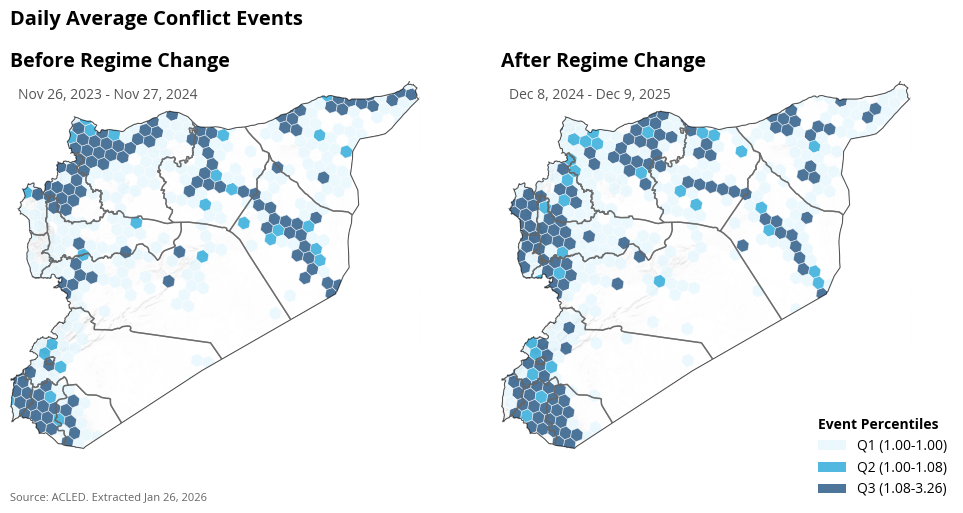

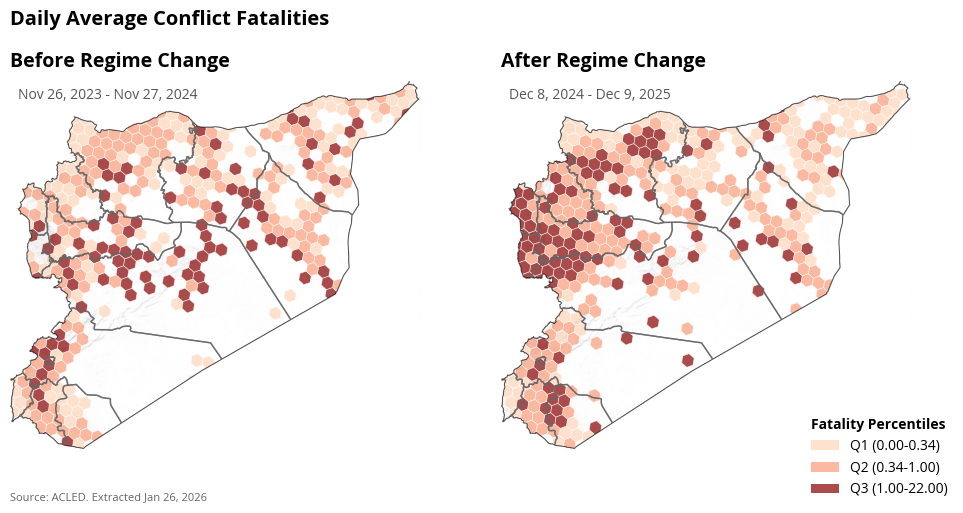

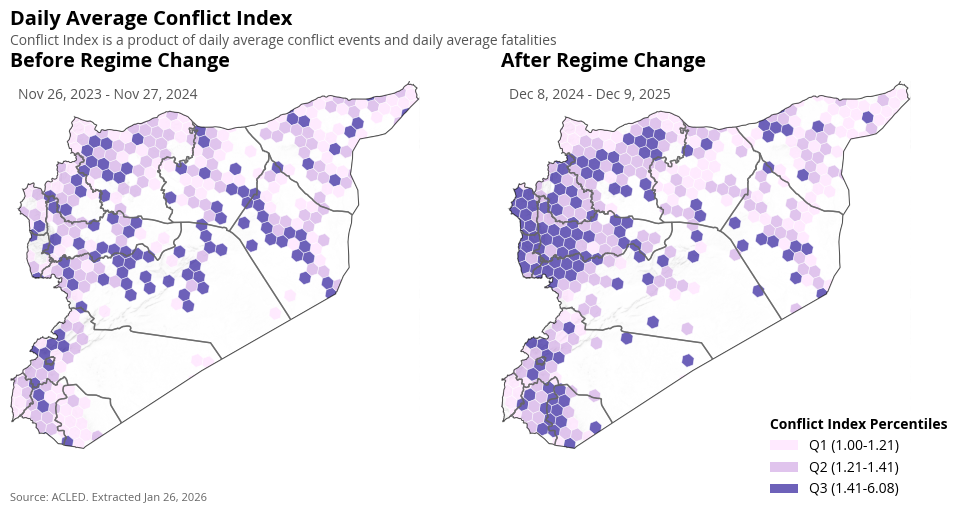

/Users/ssarva/syria-economic-monitor/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Open Sans.
  fig.canvas.print_figure(bytes_io, **kw)


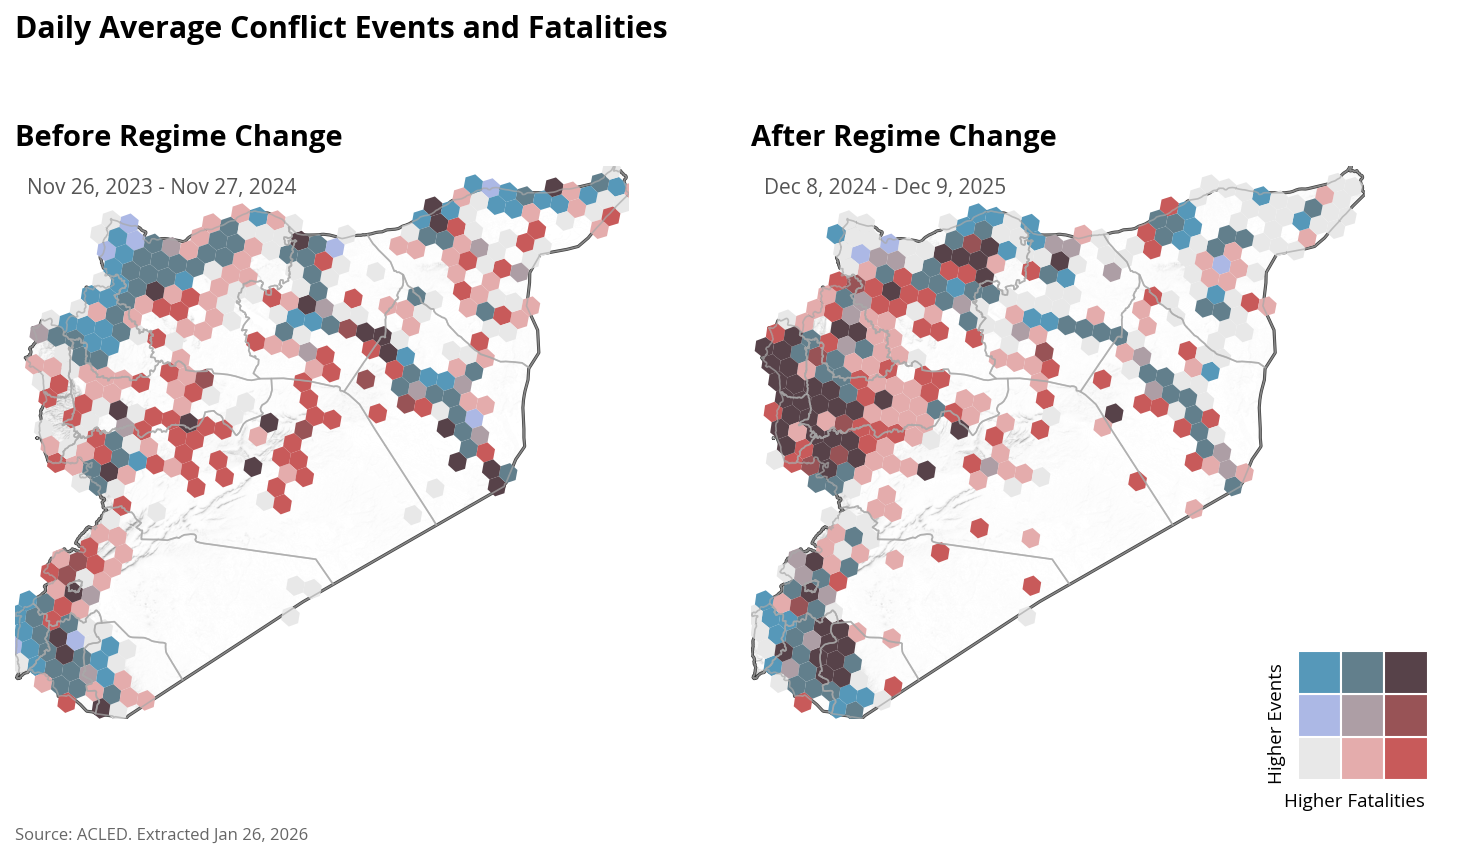

In [44]:
fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean,
    "Daily Average Conflict Events",
    measure="nrEvents",
    category_list=category_list,
    custom_colors=["#E3F6FD", "#089BD4", "#023B6F"],
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    date_ranges={
        "Before Regime Change": "Nov 26, 2023 - Nov 27, 2024",
        "After Regime Change": "Dec 8, 2024 - Dec 9, 2025",
    },
    legend_title="Event Percentiles",
)

fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean,
    "Daily Average Conflict Fatalities",
    measure="nrFatalities",
    category_list=category_list,
    custom_colors=["#ffd6b9", "#f99c78", "#870000"],
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    date_ranges={
        "Before Regime Change": "Nov 26, 2023 - Nov 27, 2024",
        "After Regime Change": "Dec 8, 2024 - Dec 9, 2025",
    },
    legend_title="Fatality Percentiles",
)

fig, ax = visuals.get_h3_maps(
    conflict_daily_h3_mean,
    title="Daily Average Conflict Index",
    subtitle="Conflict Index is a product of daily average conflict events and daily average fatalities",
    measure="conflict_intensity_index_op1",
    category_list=category_list,
    custom_colors=["#FFE2FF", "#D3ACE6", "#2F1E9C"],
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=0.5,
    date_ranges={
        "Before Regime Change": "Nov 26, 2023 - Nov 27, 2024",
        "After Regime Change": "Dec 8, 2024 - Dec 9, 2025",
    },
    legend_title="Conflict Index Percentiles",
)

fig, ax = visuals.create_bivariate_map_with_basemap(
    conflict_data=conflict_daily_h3_mean,
    category_list=category_list,
    country_boundary=syria_adm0,
    admin1_boundary=syria_adm1,
    main_title="Daily Average Conflict Events and Fatalities",
    basemap_choice=MAPBOX_BASEMAP_URL,
    basemap_alpha=1,
    hexagon_alpha=1,
    date_ranges={
        "Before Regime Change": "Nov 26, 2023 - Nov 27, 2024",
        "After Regime Change": "Dec 8, 2024 - Dec 9, 2025",
    },
)

The average conflict events and conflict fatalities per day has increased in the Lattakia,  of the country after regime change. In some parts around Damascus the conflicts reduced, while they increased in others. 

In [45]:
conflict_type = processing.get_acled_by_admin(
    syria_h3,
    data,
    columns=["h3_index", "category", "event_type", "sub_event_type"],
    freq="D",
)
conflict_type.drop(columns=["index"], inplace=True)

# calculating average 'daily' conflict index
conflict_type = (
    conflict_type.groupby(["category", "event_type", "sub_event_type"])[
        ["nrEvents", "nrFatalities"]
    ]
    .sum()
    .reset_index()
)

## Major Conflict Types

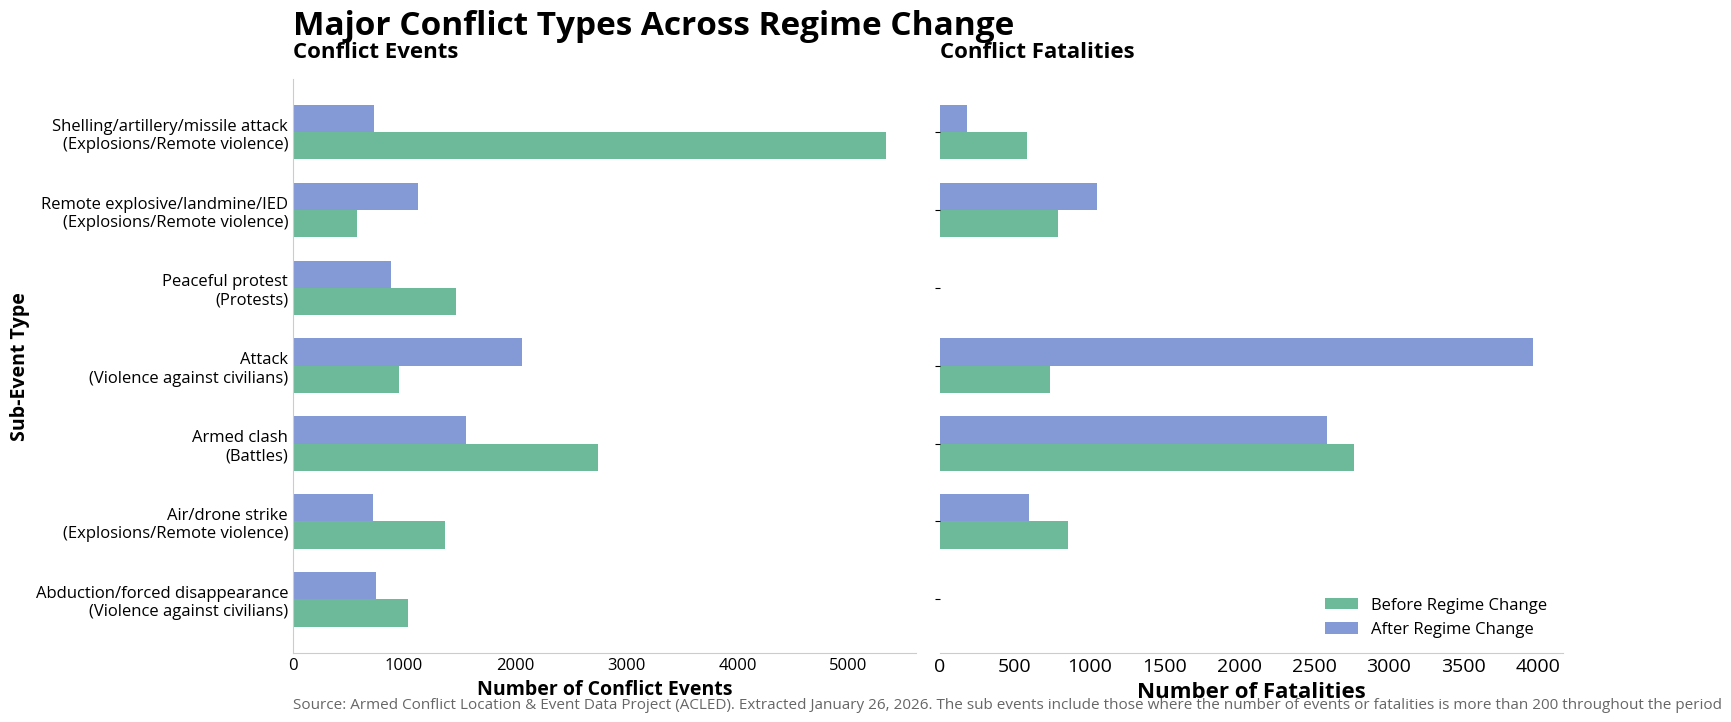

In [95]:
import matplotlib.pyplot as plt

# Set Open Sans font
plt.rcParams["font.family"] = "Open Sans"

# Filter out sub_event_types with less than 50 events or fatalities
conflict_type_filtered = conflict_type.groupby(["sub_event_type", "category"]).filter(
    lambda x: (x["nrEvents"].sum() >= 200) or (x["nrFatalities"].sum() >= 200)
)

# Create a mapping of sub_event_type to event_type
sub_to_event_map = (
    conflict_type_filtered.groupby("sub_event_type")["event_type"].first().to_dict()
)

# Pivot the data for both events and fatalities
conflict_pivot_events = conflict_type_filtered.pivot_table(
    index="sub_event_type",
    columns="category",
    values="nrEvents",
    aggfunc="sum",
    fill_value=0,
)

conflict_pivot_fatalities = conflict_type_filtered.pivot_table(
    index="sub_event_type",
    columns="category",
    values="nrFatalities",
    aggfunc="sum",
    fill_value=0,
)

# Create labels with event_type in brackets
labels_with_event_type = [
    f"{sub_event}\n({sub_to_event_map[sub_event]})"
    for sub_event in conflict_pivot_events.index
]

# Create side-by-side horizontal bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Set colors
color_before = "#54AE89"
color_after = "#6D88D1"
spine_color = "#CCCCCC"

# Set the bar height and positions
y = range(len(conflict_pivot_events.index))
height = 0.35

# Plot 1: Events
ax1.barh(
    [i - height / 2 for i in y],
    conflict_pivot_events["Before Regime Change"],
    height,
    label="Before Regime Change",
    color=color_before,
    alpha=0.85,
)
ax1.barh(
    [i + height / 2 for i in y],
    conflict_pivot_events["After Regime Change"],
    height,
    label="After Regime Change",
    color=color_after,
    alpha=0.85,
)

ax1.set_xlabel(
    "Number of Conflict Events", fontsize=14, fontweight="bold", fontfamily="Open Sans"
)
ax1.set_ylabel("Sub-Event Type", fontsize=14, fontweight="bold", fontfamily="Open Sans")
ax1.set_title(
    "Conflict Events",
    fontsize=16,
    fontweight="bold",
    pad=15,
    fontfamily="Open Sans",
    loc="left",
)
ax1.set_yticks(y)
ax1.set_yticklabels(labels_with_event_type, fontfamily="Open Sans", fontsize=14)
ax1.tick_params(axis="x", labelsize=12, length=0)
ax1.tick_params(axis="y", labelsize=12, length=0)
for label in ax1.get_yticklabels():
    label.set_fontfamily("Open Sans")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_color(spine_color)
ax1.spines["bottom"].set_color(spine_color)
ax1.grid(False)

# Plot 2: Fatalities
ax2.barh(
    [i - height / 2 for i in y],
    conflict_pivot_fatalities["Before Regime Change"],
    height,
    label="Before Regime Change",
    color=color_before,
    alpha=0.85,
)
ax2.barh(
    [i + height / 2 for i in y],
    conflict_pivot_fatalities["After Regime Change"],
    height,
    label="After Regime Change",
    color=color_after,
    alpha=0.85,
)

ax2.set_xlabel(
    "Number of Fatalities", fontsize=16, fontweight="bold", fontfamily="Open Sans"
)
ax2.set_title(
    "Conflict Fatalities",
    fontsize=16,
    fontweight="bold",
    pad=15,
    fontfamily="Open Sans",
    loc="left",
)
ax2.tick_params(axis="x", labelsize=14, length=0)
for label in ax2.get_xticklabels():
    label.set_fontfamily("Open Sans")
ax2.legend(loc="lower right", frameon=False, prop={"family": "Open Sans", "size": 12})
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["bottom"].set_color(spine_color)
ax2.grid(False)

# Add main title
fig.suptitle(
    "Major Conflict Types Across Regime Change",
    fontsize=24,
    fontweight="bold",
    fontfamily="Open Sans",
    x=0.08,
    ha="left",
    y=0.999,
)

# Add source at the bottom left
fig.text(
    0.08,
    0.001,
    f"Source: Armed Conflict Location & Event Data Project (ACLED). Extracted {extracted_date_formatted}. The sub events include those where the number of events or fatalities is more than 200 throughout the period",
    ha="left",
    fontsize=11,
    fontfamily="Open Sans",
    style="italic",
    color="#666666",
)

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.08, left=0.08)
plt.show()

## Major Conflict Topics

This section uses natural language processing to identify distinct protest topics/themes:

**Method**: TF-IDF (Term Frequency-Inverse Document Frequency) with K-means clustering identifies groups of conflict events that share similar language and themes.

**Process**:
1. **Text Preprocessing**: Apply word normalization and custom stopwords to clean the data
2. **TF-IDF Vectorization**: Convert text to numerical features, weighting words by their importance


**Time Period Analysis**: We run this analysis separately for before and after regime change

In [47]:
# import pandas as pd
# import numpy as np
# from acled_conflict_analysis.text_analysis import (
#     plot_wordcloud_comparison,
#     get_word_counts,
#     get_ngram_counts,
#     get_tfidf_word_frequencies,
#     custom_stopwords
# )

# # Auto-reload modules when they change
# %load_ext autoreload
# %autoreload 2

In [77]:
before_regime = data[data["category"] == "Before Regime Change"]
after_regime = data[data["category"] == "After Regime Change"]

In [88]:
additional_stopwords = [
    "fatality",
    "fatalities",
    "casualty",
    "casualties",
    "injury",
    "injuries",
    "unknown",
    "countryside",
    "regime",
    "syria",
    "clash",
    "man",
    "fighter",
    "killed",
    "killing",
]
custom_stopwords = custom_stopwords + additional_stopwords

In [89]:
word_counts_before_regime = get_word_counts(
    before_regime, column_name="notes", custom_stopwords=custom_stopwords
)

word_counts_after_regime = get_word_counts(
    after_regime, column_name="notes", custom_stopwords=custom_stopwords
)

In [90]:
from acled_conflict_analysis.text_analysis import get_tfidf_word_frequencies

word_normalizations = {
    "moroccan": "morocco",
    "moroccans": "morocco",
    "palestinian": "palestine",
    "palestinians": "palestine",
    "israeli": "israel",
    "israelis": "israel",
    "egyptian": "egypt",
    "egyptians": "egypt",
    "iraqi": "iraq",
    "iraqis": "iraq",
    "syrian": "syria",
    "syrians": "syria",
    "lebanese": "lebanon",
    "yemeni": "yemen",
    "yemenis": "yemen",
    "salaries": "salary",
    "retirees": "retirement",
    "retired": "retirement",
}

# Add normalized forms to stopwords to ensure they're removed after normalization
normalized_stopwords = custom_stopwords + list(set(word_normalizations.values()))

tfidf_before_regime = get_tfidf_word_frequencies(
    df=before_regime,
    text_column="notes",
    custom_stopwords=normalized_stopwords,
    word_normalizations=word_normalizations,
    top_n=100,
)

tfidf_after_regime = get_tfidf_word_frequencies(
    df=after_regime,
    text_column="notes",
    custom_stopwords=normalized_stopwords,
    word_normalizations=word_normalizations,
    top_n=100,
)

# Manually filter out stopwords from results (in case normalization happened after initial filtering)
stopwords_set = set(normalized_stopwords)
tfidf_before_regime = {
    k: v for k, v in tfidf_before_regime.items() if k not in stopwords_set
}
tfidf_after_regime = {
    k: v for k, v in tfidf_after_regime.items() if k not in stopwords_set
}

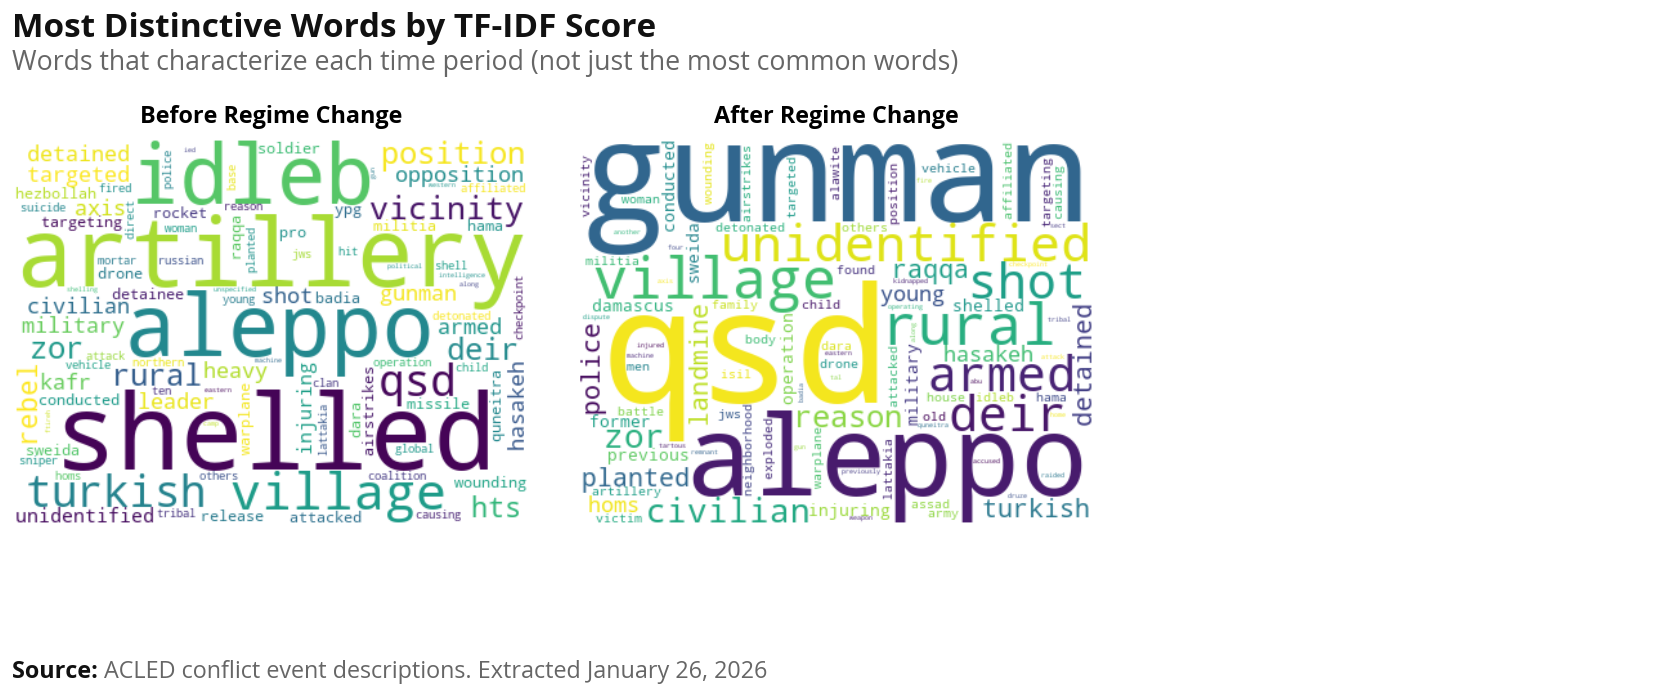

In [91]:
plot_wordcloud_comparison(
    word_freq_dicts=[tfidf_before_regime, tfidf_after_regime],
    subplot_titles=["Before Regime Change", "After Regime Change"],
    main_title="Most Distinctive Words by TF-IDF Score",
    subtitle="Words that characterize each time period (not just the most common words)",
    note=f"ACLED conflict event descriptions. Extracted {extracted_date_formatted}",
    figsize=(14, 6),
    ncols=3,
)